In [1]:
import pandas as pd

import numpy as np

import logging

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns

In [2]:
df_heart = pd.read_csv('heart.csv', engine='c')
df_heart.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
X=df_heart[['age', 'sex', 'cp', 'trestbps',  'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']]
# Labels
y=df_heart['target']

# Split dataset into training set and test set
]
#
]70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                          random_state=100,
                                                          shuffle=True,
                                                          stratify=y)

In [14]:
import logging
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')


def setup_logger(name, log_file, level=logging.INFO):
    """Function setup as many loggers as you want"""

    handler = logging.FileHandler(log_file)        
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

def reset_logger(name):
    import os
    os.remove(name)

In [12]:
#from EnginneringForest import EnginneringForest
class BaseEnginnering(object):
    def __init__(self):
        pass
    
    def get_subset(self, X, y, columns):
        from pandas import DataFrame

        df_tmp = X.copy()
        df_tmp.insert(loc=(len(df_tmp.columns)), column='target', value=y)
        
        df_subset = (df_tmp.loc[:, columns], df_tmp['target'])
        
        return df_subset
    
    def arrangement_features(self, features: list,  n_selected: int) -> list:
        from itertools import combinations
        permsList = list(combinations(features, r=n_selected))
        
        return permsList
####
class ClassifierEnginneringForest(BaseEnginnering):
    
    def __init__(self):
        self.criterion = 'entropy'
        self.splitter='best'
        self.max_depth=None
        self.min_samples_split=2
        self.min_samples_leaf=1
        self.min_weight_fraction_leaf=0
        self.max_features=None
        self.random_state = 200
        self.max_leaf_nodes=None
        #min_impurity_decrease=0,
        #min_impurity_split=1e-7,
        self.class_weight=None
        self.presort=False
        
    def make_base_estimator(self):
        clf = DecisionTreeClassifier(self.criterion)
        return clf
    
    def make_lote_base_estimator(self):
        pass
###
class EnginneringForest(ClassifierEnginneringForest):

    def __init__(self, select_features):
        self.estimators_ = []
        self.select_features_ = select_features
        self.group_features_ = []
        self.df_predict_ = pd.DataFrame()
        self.n_features_ = 0
        self.n_samples_ = 0
        self.name_features_ = []
        super().__init__()

    def build(self, features_set):
        """ Cria um vetor com o número de árvores igual ao número de subconjuntos possíveis"""
        self.group_features_ = self.arrangement_features(features=features_set, n_selected=self.select_features_)
        self.estimators_ = [self.make_base_estimator() for gf in self.group_features_]

    def train(self, X, y, group_feature, estimator):
        subset_xdata, subset_ydata = self.get_subset(X, y, group_feature)
        return estimator.fit(subset_xdata, subset_ydata)
        
    def fit(self, X, y):
        self.n_samples_, self.n_features_ = X.shape
        self.name_features_ = X.columns

        # Cria a floresta
        self.build(features_set=self.name_features_)

        # Treina as arvores individualmente
        self.estimators_ = [self.train(X, y, subset_feature, estimator) 
                            for subset_feature, estimator in zip(self.group_features_, self.estimators_)]

    def voting(self):
        final_predict = []
        for i in range(self.df_predict_.shape[0]):
            class_one = list(self.df_predict_.loc[i]).count(1)
            class_zero = list(self.df_predict_.loc[i]).count(0)
            if class_one > class_zero:
                final_predict.append(1)
            else:
                final_predict.append(0)
        return final_predict 
        
    def predict(self, X):
        # É aqui que monto a (matriz nº de amostras x nº de classificadores)
        for subset_feature, estimator in zip(self.group_features_, self.estimators_):
            subset_test = X.loc[:, subset_feature]
            num_columns = len(self.df_predict_.columns)
            pattern_name_column = 'cls_' + str(num_columns)
            cls_predict = estimator.predict(subset_test)
            self.df_predict_.insert(loc=num_columns, column=pattern_name_column, value=cls_predict)
            
        return self.voting()

In [15]:
reset_logger('logger_accuracy_dataset_heart.log')
reset_logger('logger_matrix_confusion_dataset_heart.log')
logger_accuracy_eg = setup_logger('accuracy_eg', 'logger_accuracy_dataset_heart.log')
logger_matrix_confusion_eg = setup_logger('matrix_confusion_eg', 'logger_matrix_confusion_dataset_heart.log')

for n_tree in [1,2,3,4,5,6,7]:
    model_eg = EnginneringForest(select_features=n_tree)
    model_eg.fit(X_train, y_train)
    y_pred = model_eg.predict(X_test)
    
    mac = metrics.accuracy_score(y_test, y_pred)
    logger_accuracy_eg.info(str(mac))
    
    mcm = confusion_matrix(y_test,y_pred)
    logger_matrix_confusion_eg.info(str(mcm))

In [16]:
list_accuracy_eg = []
with open('logger_accuracy_dataset_heart.log', 'r') as file_object:
    for line in file_object:
        list_accuracy_eg.append(float(line.rstrip('\n').split(" ")[3]))

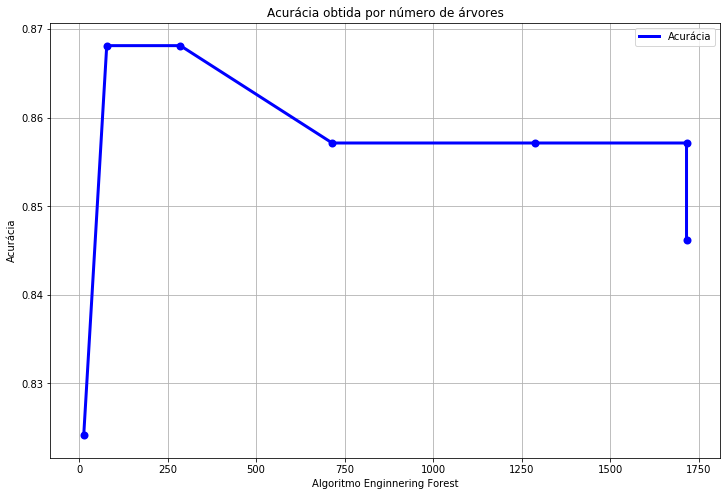

In [17]:
eixo_x1 = [13, 78, 286, 715, 1287, 1716, 1716]
eixo_y1 = list_accuracy_eg
plt.figure(figsize=(12,8))
plt.plot(eixo_x1, eixo_y1, color='blue', linewidth=3.0, label='Acurácia');
plt.scatter(eixo_x1, eixo_y1, color='blue', linewidth=2.0)
plt.title('Acurácia obtida por número de árvores')
plt.xlabel('Algoritmo Enginnering Forest')
plt.ylabel('Acurácia')
plt.grid(True)
plt.legend();